In [81]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [82]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

# ../../Data/Processed data\250 shojja.xlsx
# ../../Data/Processed data\31 shojja.xlsx
# ../../Data/Processed data\ad-din.xlsx
# ../../Data/Processed data\aichi.xlsx
# ../../Data/Processed data\Al manar.xlsx
# ../../Data/Processed data\Anowar khan.xlsx
# ../../Data/Processed data\azgol ali.xlsx
# ../../Data/Processed data\Delta medical.xlsx
# ../../Data/Processed data\dmd central.xlsx
# ../../Data/Processed data\h&h.xlsx
# ../../Data/Processed data\hfrc.xlsx
# ../../Data/Processed data\ibn sina.xlsx
# ../../Data/Processed data\islami bank.xlsx
# ../../Data/Processed data\lstm_dmc.xlsx
# ../../Data/Processed data\Medical college for women.xlsx
# ../../Data/Processed data\Metropoliton medical.xlsx
# ../../Data/Processed data\police hospital.xlsx
# ../../Data/Processed data\popular medical.xlsx
# ../../Data/Processed data\shomorita.xlsx
# ../../Data/Processed data\Square.xlsx
# ../../Data/Processed data\ssmc.xlsx
# ../../Data/Processed data\united hospital.xlsx
# ../../Data/Processed data\universal.xlsx
# ../../Data/Processed data\Uttara adhunik.xlsx

# df = read_excel('../../Data/Processed data/31 shojja.xlsx')
# df = read_excel('../../Data/Processed data/250 shojja.xlsx')
# df = read_excel('../../Data/Processed data/ad-din.xlsx')
# df = read_excel('../../Data/Processed data/aichi.xlsx')
# df = read_excel('../../Data/Processed data/Al manar.xlsx')
# df = read_excel('../../Data/Processed data/Anowar khan.xlsx')
# df = read_excel('../../Data/Processed data/azgol ali.xlsx')
# df = read_excel('../../Data/Processed data/Delta medical.xlsx')
# df = read_excel('../../Data/Processed data/dmd central.xlsx')
# df = read_excel('../../Data/Processed data/h&h.xlsx')
# df = read_excel('../../Data/Processed data/hfrc.xlsx')
# df = read_excel('../../Data/Processed data/ibn sina.xlsx')
# df = read_excel('../../Data/Processed data/islami bank.xlsx')
# df = read_excel('../../Data/Processed data/lstm_dmc.xlsx')
# df = read_excel('../../Data/Processed data/Medical college for women.xlsx')
# df = read_excel('../../Data/Processed data/Metropoliton medical.xlsx')
# df = read_excel('../../Data/Processed data/police hospital.xlsx')
# df = read_excel('../../Data/Processed data/popular medical.xlsx')
# df = read_excel('../../Data/Processed data/shomorita.xlsx')
# df = read_excel('../../Data/Processed data/Square.xlsx')
# df = read_excel('../../Data/Processed data/ssmc.xlsx')
# df = read_excel('../../Data/Processed data/united hospital.xlsx')
# df = read_excel('../../Data/Processed data/universal.xlsx')
# df = read_excel('../../Data/Processed data/Uttara adhunik.xlsx')
# df = read_excel('../../Data/Processed data/Sajeda hospital.xlsx')
# df = read_excel('../../Data/Processed data/Dhaka central.xlsx')

In [83]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [84]:
df.shape

(156, 2)

In [85]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 3
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  17  input_size:  14  num_layers:  1


In [86]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(df, window_size)

In [87]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,3.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.0,2.0,2.0,0.0,0.0,1.0,3.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,2.0,2.0,0.0,0.0,1.0,3.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0
3,2.0,0.0,0.0,1.0,3.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0
4,0.0,0.0,1.0,3.0,3.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0,2.0


In [88]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, False)

In [89]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [90]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (112, 14)  y_train.shape:  (112, 3)  X_test.shape:  (28, 14)  y_test.shape:  (28, 3)


In [91]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [92]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [93]:
model = LSTMModel(input_size, hidden_size, num_layers)

In [94]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [95]:
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

Epoch [1/500], Loss: 0.3493
Epoch [2/500], Loss: 0.4820
Epoch [3/500], Loss: 0.1648
Epoch [4/500], Loss: 0.5231
Epoch [5/500], Loss: 0.8010
Epoch [6/500], Loss: 0.5354
Epoch [7/500], Loss: 0.3063
Epoch [8/500], Loss: 0.5977
Epoch [9/500], Loss: 0.4107
Epoch [10/500], Loss: 0.6820
Epoch [11/500], Loss: 0.2823
Epoch [12/500], Loss: 0.6235
Epoch [13/500], Loss: 0.3817
Epoch [14/500], Loss: 0.4905
Epoch [15/500], Loss: 0.4745
Epoch [16/500], Loss: 0.5298
Epoch [17/500], Loss: 0.1335
Epoch [18/500], Loss: 0.2302
Epoch [19/500], Loss: 0.2500
Epoch [20/500], Loss: 0.2661
Epoch [21/500], Loss: 0.4869
Epoch [22/500], Loss: 0.4209
Epoch [23/500], Loss: 0.6802
Epoch [24/500], Loss: 0.4810
Epoch [25/500], Loss: 0.2993
Epoch [26/500], Loss: 0.2722
Epoch [27/500], Loss: 0.3438
Epoch [28/500], Loss: 0.1492
Epoch [29/500], Loss: 0.2814
Epoch [30/500], Loss: 0.4214


Epoch [31/500], Loss: 0.5368
Epoch [32/500], Loss: 0.2084
Epoch [33/500], Loss: 0.4043
Epoch [34/500], Loss: 0.3295
Epoch [35/500], Loss: 0.2044
Epoch [36/500], Loss: 0.3262
Epoch [37/500], Loss: 0.2194
Epoch [38/500], Loss: 0.3369
Epoch [39/500], Loss: 0.4989
Epoch [40/500], Loss: 0.3662
Epoch [41/500], Loss: 0.3488
Epoch [42/500], Loss: 0.4474
Epoch [43/500], Loss: 0.3065
Epoch [44/500], Loss: 0.3767
Epoch [45/500], Loss: 0.4844
Epoch [46/500], Loss: 0.1683
Epoch [47/500], Loss: 0.3817
Epoch [48/500], Loss: 0.2674
Epoch [49/500], Loss: 0.3132
Epoch [50/500], Loss: 0.3428
Epoch [51/500], Loss: 0.1046
Epoch [52/500], Loss: 0.4089
Epoch [53/500], Loss: 0.3020
Epoch [54/500], Loss: 0.5903
Epoch [55/500], Loss: 0.3096
Epoch [56/500], Loss: 0.2349
Epoch [57/500], Loss: 0.2355
Epoch [58/500], Loss: 0.2228
Epoch [59/500], Loss: 0.3128
Epoch [60/500], Loss: 0.4967
Epoch [61/500], Loss: 0.4319
Epoch [62/500], Loss: 0.1197
Epoch [63/500], Loss: 0.5263
Epoch [64/500], Loss: 0.1848
Epoch [65/500]

In [96]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 0.0608


In [97]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
# y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
# predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

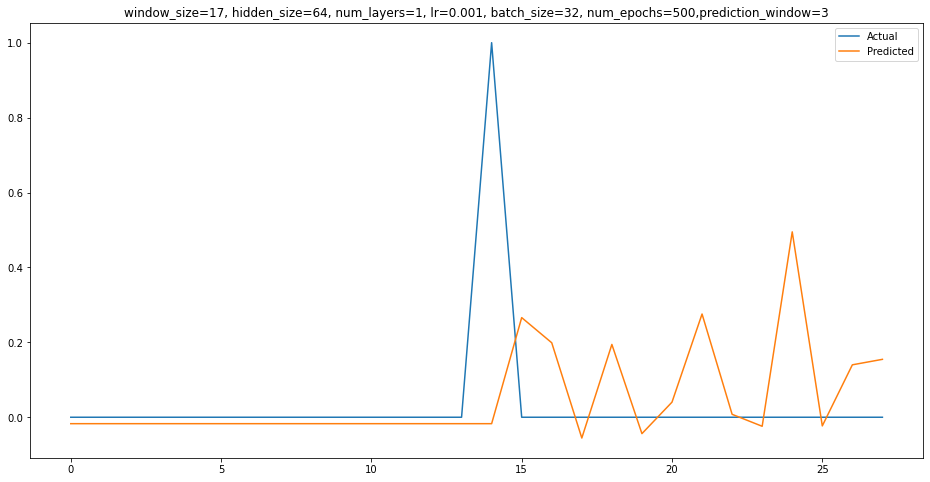

In [98]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [99]:
# MAE, MSE, RMSE losses
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_1, predictions_1)
mse = mean_squared_error(y_test_1, predictions_1)
rmse = np.sqrt(mse)
print("MAE: ", mae, " MSE: ", mse, " RMSE: ", rmse)

MAE:  0.11345250874624721  MSE:  0.05567973118427526  RMSE:  0.23596552965269155


In [100]:
# print errors in 2 decimal places
print("MAE: {:.2f}".format(mae), " MSE: {:.2f}".format(mse), " RMSE: {:.2f}".format(rmse))

MAE: 0.11  MSE: 0.06  RMSE: 0.24
